In [1]:
pip install codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.2/504.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.4/386.4 kB 28.5 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 2.5.0
    Uninstalling termcolor-2.5.0:
      Successfully uninstalled termcolor-2.5.0
  Attempting uninstall: prompt_toolkit
    Found existing installation: prompt_toolkit 3.0.48
    Uninstalling prompt_toolkit-3.0.48:
      Successfully uninstalled prompt_toolkit-3.0.48
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ip

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torchvision import models, datasets, transforms
import time
import os
import subprocess
import numpy as np
from tqdm import tqdm
import codecarbon
from thop import profile

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the transforms for the dataset with additional augmentations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the CIFAR-10 dataset
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split the full training dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders for the train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Print dataset sizes for debugging
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Load the pretrained VGG16 model and modify the classifier
model = models.vgg16(pretrained=True)
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Dropout(0.5),  # Increased dropout for regularization
    nn.Linear(input_lastLayer, 10)
)
model = model.to(device)

# Define loss function and optimizer with learning rate scheduler
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Tracking metrics for analysis
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Use CodeCarbon for system-wide energy consumption tracking
tracker = codecarbon.EmissionsTracker()
tracker.start()

# Function to get GPU power consumption using nvidia-smi
def get_gpu_power():
    try:
        # Query power.draw from nvidia-smi
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=power.draw', '--format=csv,nounits,noheader'],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        power_draws = result.stdout.strip().split('\n')
        power_draws = [float(p) for p in power_draws]
        avg_power_draw = sum(power_draws) / len(power_draws)  # Average power across GPUs
        return avg_power_draw  # in watts
    except Exception as e:
        print(f"Error getting GPU power: {e}")
        return 0.0

# Tracking GPU-specific energy consumption
gpu_power_readings = []

# Training loop with GPU power monitoring
epochs = 30
start_training_time = time.time()

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Record GPU power usage
        gpu_power_readings.append(get_gpu_power())

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # Append metrics for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val

    # Append metrics for plotting
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Epoch [{epoch+1}/{epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

training_time = time.time() - start_training_time

# Stop the CodeCarbon tracker after training
emissions = tracker.stop()

# Calculate average GPU power and total GPU energy consumption (in kWh)
avg_gpu_power = sum(gpu_power_readings) / len(gpu_power_readings) if gpu_power_readings else 0.0
energy_consumption_gpu = (avg_gpu_power * training_time) / 3600  # Convert to kWh

# Save the model after training
model_path = "trained_vgg16_model.pth"
torch.save(model.state_dict(), model_path)

# Model analysis metrics
param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
torch.save(model.state_dict(), "temp_model.pth")
model_size = os.path.getsize("temp_model.pth") / (1024 * 1024)  # Convert bytes to MB
os.remove("temp_model.pth")

# FLOPs calculation
dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, _ = profile(model, inputs=(dummy_input,), verbose=False)

# Inference time calculation
model.eval()
inference_start = time.time()
with torch.no_grad():
    for _ in range(100):
        _ = model(dummy_input)
inference_time = (time.time() - inference_start) / 100

# Final energy and emissions report
print("\n--- Model Analysis ---")
print(f"Parameter Count: {param_count}")
print(f"Model Size: {model_size:.2f} MB")
print(f"FLOPs: {flops / 1e9:.2f} GFLOPs")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Average Inference Time: {inference_time:.6f} seconds")

print("\n--- Energy and Emissions Report ---")
print(f"CO2 Emissions (CodeCarbon): {emissions:.6f} kg")
print(f"Average GPU Power Consumption: {avg_gpu_power:.2f} W")
print(f"Total GPU Energy Consumption: {energy_consumption_gpu:.6f} kWh")


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Validation set size: 10000
Test set size: 10000


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[codecarbon INFO @ 03:15:54] [setup] RAM Tracking...
[codecarbon INFO @ 03:15:54] [setup] GPU Tracking...
[codecarbon INFO @ 03:15:54] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 03:15

Epoch [1/30], Train Loss: 1.3917, Train Accuracy: 51.55%
Epoch [1/30], Val Loss: 1.0711, Val Accuracy: 65.36%


Epoch 2/30 - Training:  19%|█▊        | 117/625 [00:12<00:47, 10.72it/s][codecarbon INFO @ 03:17:26] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:17:26] Energy consumed for all GPUs : 0.001545 kWh. Total GPU Power : 59.82829370376669 W
[codecarbon INFO @ 03:17:26] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:17:26] 0.002727 kWh of electricity used since the beginning.
Epoch 2/30 - Training:  42%|████▏     | 261/625 [00:27<00:33, 10.77it/s][codecarbon INFO @ 03:17:41] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:17:41] Energy consumed for all GPUs : 0.001816 kWh. Total GPU Power : 65.16469576297568 W
[codecarbon INFO @ 03:17:41] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:17:41] 0.003195 kWh of electricity used since the beginning.
Epoch 2/30 - Training:  65%|██████▍   | 405/625 [00:42<00:21, 10

Epoch [2/30], Train Loss: 0.8627, Train Accuracy: 71.98%
Epoch [2/30], Val Loss: 0.7339, Val Accuracy: 75.91%


Epoch 3/30 - Training:  16%|█▌        | 98/625 [00:11<00:50, 10.54it/s][codecarbon INFO @ 03:18:41] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:18:41] Energy consumed for all GPUs : 0.002825 kWh. Total GPU Power : 57.32050854094586 W
[codecarbon INFO @ 03:18:41] Energy consumed for all CPUs : 0.001949 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:18:41] 0.004991 kWh of electricity used since the beginning.
Epoch 3/30 - Training:  39%|███▊      | 241/625 [00:26<00:35, 10.69it/s][codecarbon INFO @ 03:18:56] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:18:56] Energy consumed for all GPUs : 0.003095 kWh. Total GPU Power : 64.95261886865423 W
[codecarbon INFO @ 03:18:56] Energy consumed for all CPUs : 0.002126 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:18:56] 0.005458 kWh of electricity used since the beginning.
Epoch 3/30 - Training:  61%|██████▏   | 384/625 [00:41<00:22, 10.

Epoch [3/30], Train Loss: 0.7215, Train Accuracy: 76.70%
Epoch [3/30], Val Loss: 0.6239, Val Accuracy: 79.21%


Epoch 4/30 - Training:  12%|█▏        | 77/625 [00:09<00:50, 10.85it/s][codecarbon INFO @ 03:19:56] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:19:56] Energy consumed for all GPUs : 0.004109 kWh. Total GPU Power : 53.64072435341886 W
[codecarbon INFO @ 03:19:56] Energy consumed for all CPUs : 0.002835 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:19:56] 0.007261 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:19:56] 0.008550 g.CO2eq/s mean an estimation of 269.6209370761193 kg.CO2eq/year
Epoch 4/30 - Training:  35%|███▌      | 221/625 [00:24<00:38, 10.57it/s][codecarbon INFO @ 03:20:11] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:20:11] Energy consumed for all GPUs : 0.004379 kWh. Total GPU Power : 64.82150340173398 W
[codecarbon INFO @ 03:20:11] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:20:11] 0.007727 kWh of e

Epoch [4/30], Train Loss: 0.6419, Train Accuracy: 79.26%
Epoch [4/30], Val Loss: 0.6501, Val Accuracy: 78.64%


Epoch 5/30 - Training:   9%|▉         | 55/625 [00:06<00:54, 10.37it/s][codecarbon INFO @ 03:21:11] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:21:11] Energy consumed for all GPUs : 0.005390 kWh. Total GPU Power : 50.41560286464855 W
[codecarbon INFO @ 03:21:11] Energy consumed for all CPUs : 0.003720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:21:11] 0.009525 kWh of electricity used since the beginning.
Epoch 5/30 - Training:  32%|███▏      | 199/625 [00:21<00:39, 10.67it/s][codecarbon INFO @ 03:21:26] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:21:26] Energy consumed for all GPUs : 0.005660 kWh. Total GPU Power : 64.81503402983377 W
[codecarbon INFO @ 03:21:26] Energy consumed for all CPUs : 0.003897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:21:26] 0.009992 kWh of electricity used since the beginning.
Epoch 5/30 - Training:  55%|█████▌    | 345/625 [00:36<00:26, 10.

Epoch [5/30], Train Loss: 0.5755, Train Accuracy: 81.29%
Epoch [5/30], Val Loss: 0.5650, Val Accuracy: 80.67%


Epoch 6/30 - Training:   7%|▋         | 42/625 [00:05<00:54, 10.65it/s][codecarbon INFO @ 03:22:26] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:22:26] Energy consumed for all GPUs : 0.006675 kWh. Total GPU Power : 48.280772715072224 W
[codecarbon INFO @ 03:22:26] Energy consumed for all CPUs : 0.004605 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:22:26] 0.011794 kWh of electricity used since the beginning.
Epoch 6/30 - Training:  30%|███       | 189/625 [00:20<00:40, 10.90it/s][codecarbon INFO @ 03:22:41] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:22:41] Energy consumed for all GPUs : 0.006943 kWh. Total GPU Power : 64.51425640521178 W
[codecarbon INFO @ 03:22:41] Energy consumed for all CPUs : 0.004782 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:22:41] 0.012260 kWh of electricity used since the beginning.
Epoch 6/30 - Training:  53%|█████▎    | 330/625 [00:35<00:28, 10

Epoch [6/30], Train Loss: 0.5435, Train Accuracy: 82.19%
Epoch [6/30], Val Loss: 0.5469, Val Accuracy: 82.01%


Epoch 7/30 - Training:   3%|▎         | 20/625 [00:02<00:58, 10.41it/s][codecarbon INFO @ 03:23:41] Energy consumed for RAM : 0.000613 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:23:41] Energy consumed for all GPUs : 0.007955 kWh. Total GPU Power : 47.88811415047337 W
[codecarbon INFO @ 03:23:41] Energy consumed for all CPUs : 0.005491 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:23:41] 0.014059 kWh of electricity used since the beginning.
Epoch 7/30 - Training:  26%|██▋       | 165/625 [00:17<00:42, 10.87it/s][codecarbon INFO @ 03:23:56] Energy consumed for all GPUs : 0.008223 kWh. Total GPU Power : 64.38745142386685 W
[codecarbon INFO @ 03:23:56] Energy consumed for all CPUs : 0.005668 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:23:56] 0.014525 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:23:56] 0.008539 g.CO2eq/s mean an estimation of 269.2909250367732 kg.CO2eq/year
Epoch 7/30 - Training:  49%|████▉     | 308/625 [00:32<00:29, 10.

Epoch [7/30], Train Loss: 0.5132, Train Accuracy: 83.64%
Epoch [7/30], Val Loss: 0.5176, Val Accuracy: 82.84%


Epoch 8/30 - Training:   0%|          | 0/625 [00:00<?, ?it/s][codecarbon INFO @ 03:24:56] Energy consumed for RAM : 0.000712 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:24:56] Energy consumed for all GPUs : 0.009232 kWh. Total GPU Power : 47.027707417164294 W
[codecarbon INFO @ 03:24:56] Energy consumed for all CPUs : 0.006376 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:24:56] 0.016321 kWh of electricity used since the beginning.
Epoch 8/30 - Training:  23%|██▎       | 142/625 [00:15<00:45, 10.68it/s][codecarbon INFO @ 03:25:11] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:25:11] Energy consumed for all GPUs : 0.009500 kWh. Total GPU Power : 64.31078269839715 W
[codecarbon INFO @ 03:25:11] Energy consumed for all CPUs : 0.006554 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:25:11] 0.016786 kWh of electricity used since the beginning.
Epoch 8/30 - Training:  46%|████▌     | 287/625 [00:30<00:32, 10.32it/s][

Epoch [8/30], Train Loss: 0.4803, Train Accuracy: 84.21%
Epoch [8/30], Val Loss: 0.5511, Val Accuracy: 81.88%


Epoch 9/30 - Training:  20%|██        | 125/625 [00:13<00:46, 10.78it/s][codecarbon INFO @ 03:26:26] Energy consumed for RAM : 0.000831 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:26:26] Energy consumed for all GPUs : 0.010781 kWh. Total GPU Power : 60.957180963129154 W
[codecarbon INFO @ 03:26:26] Energy consumed for all CPUs : 0.007440 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:26:26] 0.019052 kWh of electricity used since the beginning.
Epoch 9/30 - Training:  43%|████▎     | 268/625 [00:28<00:33, 10.74it/s][codecarbon INFO @ 03:26:41] Energy consumed for RAM : 0.000851 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:26:41] Energy consumed for all GPUs : 0.011051 kWh. Total GPU Power : 64.79974743550677 W
[codecarbon INFO @ 03:26:41] Energy consumed for all CPUs : 0.007617 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:26:41] 0.019519 kWh of electricity used since the beginning.
Epoch 9/30 - Training:  66%|██████▌   | 412/625 [00:43<00:20, 1

Epoch [9/30], Train Loss: 0.4618, Train Accuracy: 84.81%
Epoch [9/30], Val Loss: 0.4874, Val Accuracy: 84.06%


Epoch 10/30 - Training:  17%|█▋        | 107/625 [00:12<00:48, 10.64it/s][codecarbon INFO @ 03:27:41] Energy consumed for RAM : 0.000930 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:27:41] Energy consumed for all GPUs : 0.012062 kWh. Total GPU Power : 58.65640874293539 W
[codecarbon INFO @ 03:27:41] Energy consumed for all CPUs : 0.008326 kWh. Total CPU Power : 42.5 W
Epoch 10/30 - Training:  40%|████      | 253/625 [00:27<00:35, 10.55it/s][codecarbon INFO @ 03:27:56] Energy consumed for RAM : 0.000950 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:27:56] Energy consumed for all GPUs : 0.012332 kWh. Total GPU Power : 65.01442093737609 W
[codecarbon INFO @ 03:27:56] Energy consumed for all CPUs : 0.008503 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:27:56] 0.021785 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:27:56] 0.008543 g.CO2eq/s mean an estimation of 269.4034900631888 kg.CO2eq/year
Epoch 10/30 - Training:  64%|██████▎   | 39

Epoch [10/30], Train Loss: 0.4382, Train Accuracy: 85.61%
Epoch [10/30], Val Loss: 0.4812, Val Accuracy: 83.74%


Epoch 11/30 - Training:  16%|█▌        | 97/625 [00:11<00:49, 10.76it/s][codecarbon INFO @ 03:28:56] Energy consumed for RAM : 0.001029 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:28:56] Energy consumed for all GPUs : 0.013350 kWh. Total GPU Power : 56.08854666303666 W
[codecarbon INFO @ 03:28:56] Energy consumed for all CPUs : 0.009211 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:28:56] 0.023590 kWh of electricity used since the beginning.
Epoch 11/30 - Training:  39%|███▊      | 241/625 [00:26<00:36, 10.64it/s][codecarbon INFO @ 03:29:11] Energy consumed for RAM : 0.001049 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:29:11] Energy consumed for all GPUs : 0.013622 kWh. Total GPU Power : 65.48266749145247 W
[codecarbon INFO @ 03:29:11] Energy consumed for all CPUs : 0.009388 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:29:11] 0.024060 kWh of electricity used since the beginning.
Epoch 11/30 - Training:  62%|██████▏   | 385/625 [00:41<00:22, 

Epoch [11/30], Train Loss: 0.4226, Train Accuracy: 86.08%
Epoch [11/30], Val Loss: 0.5220, Val Accuracy: 82.77%


Epoch 12/30 - Training:  14%|█▎        | 85/625 [00:08<00:51, 10.47it/s][codecarbon INFO @ 03:30:11] Energy consumed for RAM : 0.001128 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:30:11] Energy consumed for all GPUs : 0.014636 kWh. Total GPU Power : 54.40046937873742 W
[codecarbon INFO @ 03:30:11] Energy consumed for all CPUs : 0.010097 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:30:11] 0.025861 kWh of electricity used since the beginning.
Epoch 12/30 - Training:  37%|███▋      | 229/625 [00:23<00:37, 10.59it/s][codecarbon INFO @ 03:30:26] Energy consumed for RAM : 0.001148 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:30:26] Energy consumed for all GPUs : 0.014907 kWh. Total GPU Power : 65.06774259526736 W
[codecarbon INFO @ 03:30:26] Energy consumed for all CPUs : 0.010274 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:30:26] 0.026328 kWh of electricity used since the beginning.
Epoch 12/30 - Training:  60%|██████    | 375/625 [00:38<00:23, 

Epoch [12/30], Train Loss: 0.4071, Train Accuracy: 86.69%
Epoch [12/30], Val Loss: 0.5072, Val Accuracy: 83.30%


Epoch 13/30 - Training:  12%|█▏        | 73/625 [00:07<00:53, 10.25it/s][codecarbon INFO @ 03:31:26] Energy consumed for RAM : 0.001227 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:31:26] Energy consumed for all GPUs : 0.015923 kWh. Total GPU Power : 52.666447776222235 W
[codecarbon INFO @ 03:31:26] Energy consumed for all CPUs : 0.010982 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:31:26] 0.028132 kWh of electricity used since the beginning.
Epoch 13/30 - Training:  35%|███▌      | 219/625 [00:22<00:36, 11.01it/s][codecarbon INFO @ 03:31:41] Energy consumed for RAM : 0.001247 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:31:41] Energy consumed for all GPUs : 0.016194 kWh. Total GPU Power : 65.04182141691322 W
[codecarbon INFO @ 03:31:41] Energy consumed for all CPUs : 0.011159 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:31:41] 0.028600 kWh of electricity used since the beginning.
Epoch 13/30 - Training:  59%|█████▊    | 366/625 [00:37<00:25,

Epoch [13/30], Train Loss: 0.4019, Train Accuracy: 86.75%
Epoch [13/30], Val Loss: 0.4712, Val Accuracy: 84.50%


Epoch 14/30 - Training:  10%|▉         | 62/625 [00:06<00:51, 11.01it/s][codecarbon INFO @ 03:32:41] Energy consumed for RAM : 0.001326 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:32:41] Energy consumed for all GPUs : 0.017206 kWh. Total GPU Power : 50.71690738837414 W
[codecarbon INFO @ 03:32:41] Energy consumed for all CPUs : 0.011868 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:32:41] 0.030400 kWh of electricity used since the beginning.
Epoch 14/30 - Training:  33%|███▎      | 205/625 [00:21<00:40, 10.41it/s][codecarbon INFO @ 03:32:56] Energy consumed for RAM : 0.001346 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:32:56] Energy consumed for all GPUs : 0.017473 kWh. Total GPU Power : 64.02778918860213 W
[codecarbon INFO @ 03:32:56] Energy consumed for all CPUs : 0.012045 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:32:56] 0.030864 kWh of electricity used since the beginning.
Epoch 14/30 - Training:  56%|█████▌    | 347/625 [00:36<00:26, 

Epoch [14/30], Train Loss: 0.3842, Train Accuracy: 87.37%
Epoch [14/30], Val Loss: 0.5226, Val Accuracy: 82.25%


Epoch 15/30 - Training:   7%|▋         | 42/625 [00:04<00:53, 10.81it/s][codecarbon INFO @ 03:33:56] Energy consumed for RAM : 0.001425 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:33:56] Energy consumed for all GPUs : 0.018488 kWh. Total GPU Power : 49.12465161625495 W
[codecarbon INFO @ 03:33:56] Energy consumed for all CPUs : 0.012753 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:33:56] 0.032666 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:33:56] 0.008554 g.CO2eq/s mean an estimation of 269.7484679406224 kg.CO2eq/year
Epoch 15/30 - Training:  30%|██▉       | 186/625 [00:19<00:40, 10.86it/s][codecarbon INFO @ 03:34:11] Energy consumed for RAM : 0.001445 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:34:11] Energy consumed for all GPUs : 0.018757 kWh. Total GPU Power : 64.6337039856221 W
[codecarbon INFO @ 03:34:11] Energy consumed for all CPUs : 0.012930 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:34:11] 0.033132 kWh of 

Epoch [15/30], Train Loss: 0.3751, Train Accuracy: 87.61%
Epoch [15/30], Val Loss: 0.4637, Val Accuracy: 85.06%


Epoch 16/30 - Training:   4%|▎         | 22/625 [00:02<00:57, 10.53it/s][codecarbon INFO @ 03:35:11] Energy consumed for RAM : 0.001524 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:35:11] Energy consumed for all GPUs : 0.019768 kWh. Total GPU Power : 47.2297387549534 W
[codecarbon INFO @ 03:35:11] Energy consumed for all CPUs : 0.013639 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:35:11] 0.034930 kWh of electricity used since the beginning.
Epoch 16/30 - Training:  26%|██▋       | 165/625 [00:17<00:42, 10.76it/s][codecarbon INFO @ 03:35:26] Energy consumed for RAM : 0.001544 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:35:26] Energy consumed for all GPUs : 0.020038 kWh. Total GPU Power : 64.79891305736395 W
[codecarbon INFO @ 03:35:26] Energy consumed for all CPUs : 0.013816 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:35:26] 0.035397 kWh of electricity used since the beginning.
Epoch 16/30 - Training:  49%|████▉     | 309/625 [00:32<00:29, 1

Epoch [16/30], Train Loss: 0.3691, Train Accuracy: 87.82%
Epoch [16/30], Val Loss: 0.5192, Val Accuracy: 83.15%


Epoch 17/30 - Training:   0%|          | 2/625 [00:00<03:05,  3.36it/s][codecarbon INFO @ 03:36:26] Energy consumed for RAM : 0.001623 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:36:26] Energy consumed for all GPUs : 0.021052 kWh. Total GPU Power : 47.91255923639069 W
[codecarbon INFO @ 03:36:26] Energy consumed for all CPUs : 0.014524 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:36:26] 0.037200 kWh of electricity used since the beginning.
Epoch 17/30 - Training:  23%|██▎       | 143/625 [00:15<00:45, 10.66it/s][codecarbon INFO @ 03:36:41] Energy consumed for RAM : 0.001643 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:36:41] Energy consumed for all GPUs : 0.021318 kWh. Total GPU Power : 63.83164422141581 W
Epoch 17/30 - Training:  23%|██▎       | 145/625 [00:15<00:45, 10.45it/s][codecarbon INFO @ 03:36:41] Energy consumed for all CPUs : 0.014701 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:36:41] 0.037662 kWh of electricity used since the be

Epoch [17/30], Train Loss: 0.3576, Train Accuracy: 88.30%
Epoch [17/30], Val Loss: 0.4311, Val Accuracy: 85.80%


Epoch 18/30 - Training:  22%|██▏       | 136/625 [00:14<00:44, 10.87it/s][codecarbon INFO @ 03:37:57] Energy consumed for all GPUs : 0.022607 kWh. Total GPU Power : 61.65528946133387 W
[codecarbon INFO @ 03:37:57] Energy consumed for all CPUs : 0.015587 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:37:57] 0.039936 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:37:57] 0.008554 g.CO2eq/s mean an estimation of 269.74709396725285 kg.CO2eq/year
Epoch 18/30 - Training:  45%|████▍     | 279/625 [00:29<00:32, 10.76it/s][codecarbon INFO @ 03:38:12] Energy consumed for RAM : 0.001761 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:38:12] Energy consumed for all GPUs : 0.022877 kWh. Total GPU Power : 65.0331314104295 W
[codecarbon INFO @ 03:38:12] Energy consumed for all CPUs : 0.015764 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:38:12] 0.040403 kWh of electricity used since the beginning.
Epoch 18/30 - Training:  68%|██████▊   | 422/625 [00:44<00:19,

Epoch [18/30], Train Loss: 0.3454, Train Accuracy: 88.67%
Epoch [18/30], Val Loss: 0.4359, Val Accuracy: 85.59%


Epoch 19/30 - Training:  19%|█▉        | 121/625 [00:13<00:47, 10.63it/s][codecarbon INFO @ 03:39:12] Energy consumed for RAM : 0.001841 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:39:12] Energy consumed for all GPUs : 0.023894 kWh. Total GPU Power : 59.527888602141374 W
[codecarbon INFO @ 03:39:12] Energy consumed for all CPUs : 0.016473 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:39:12] 0.042208 kWh of electricity used since the beginning.
Epoch 19/30 - Training:  42%|████▏     | 264/625 [00:28<00:34, 10.58it/s][codecarbon INFO @ 03:39:27] Energy consumed for RAM : 0.001860 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:39:27] Energy consumed for all GPUs : 0.024163 kWh. Total GPU Power : 64.71909308149459 W
[codecarbon INFO @ 03:39:27] Energy consumed for all CPUs : 0.016651 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:39:27] 0.042675 kWh of electricity used since the beginning.
Epoch 19/30 - Training:  65%|██████▌   | 407/625 [00:43<00:20

Epoch [19/30], Train Loss: 0.3405, Train Accuracy: 88.96%
Epoch [19/30], Val Loss: 0.4333, Val Accuracy: 85.73%


Epoch 20/30 - Training:  17%|█▋        | 106/625 [00:10<00:55,  9.43it/s][codecarbon INFO @ 03:40:27] Energy consumed for RAM : 0.001939 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:40:27] Energy consumed for all GPUs : 0.025180 kWh. Total GPU Power : 57.020273068325785 W
[codecarbon INFO @ 03:40:27] Energy consumed for all CPUs : 0.017359 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:40:27] 0.044478 kWh of electricity used since the beginning.
Epoch 20/30 - Training:  40%|████      | 250/625 [00:25<00:35, 10.45it/s][codecarbon INFO @ 03:40:42] Energy consumed for RAM : 0.001959 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:40:42] Energy consumed for all GPUs : 0.025453 kWh. Total GPU Power : 65.52828294107155 W
[codecarbon INFO @ 03:40:42] Energy consumed for all CPUs : 0.017536 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:40:42] 0.044948 kWh of electricity used since the beginning.
Epoch 20/30 - Training:  63%|██████▎   | 394/625 [00:40<00:21

Epoch [20/30], Train Loss: 0.3304, Train Accuracy: 89.05%
Epoch [20/30], Val Loss: 0.4531, Val Accuracy: 85.11%


Epoch 21/30 - Training:  13%|█▎        | 84/625 [00:08<00:50, 10.74it/s][codecarbon INFO @ 03:41:42] Energy consumed for RAM : 0.002038 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:41:42] Energy consumed for all GPUs : 0.026461 kWh. Total GPU Power : 54.073386681621265 W
[codecarbon INFO @ 03:41:42] Energy consumed for all CPUs : 0.018244 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:41:42] 0.046743 kWh of electricity used since the beginning.
Epoch 21/30 - Training:  35%|███▌      | 221/625 [00:23<00:39, 10.22it/s][codecarbon INFO @ 03:41:57] Energy consumed for RAM : 0.002058 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:41:57] Energy consumed for all GPUs : 0.026725 kWh. Total GPU Power : 63.324516668957735 W
[codecarbon INFO @ 03:41:57] Energy consumed for all CPUs : 0.018421 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:41:57] 0.047204 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:41:57] 0.008539 g.CO2eq/s mean an estim

Epoch [21/30], Train Loss: 0.3319, Train Accuracy: 89.20%
Epoch [21/30], Val Loss: 0.4934, Val Accuracy: 83.88%


Epoch 22/30 - Training:   7%|▋         | 41/625 [00:05<01:07,  8.67it/s][codecarbon INFO @ 03:42:57] Energy consumed for RAM : 0.002137 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:42:57] Energy consumed for all GPUs : 0.027723 kWh. Total GPU Power : 47.70384519963036 W
[codecarbon INFO @ 03:42:57] Energy consumed for all CPUs : 0.019130 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:42:57] 0.048991 kWh of electricity used since the beginning.
Epoch 22/30 - Training:  29%|██▉       | 184/625 [00:20<00:46,  9.43it/s][codecarbon INFO @ 03:43:12] Energy consumed for RAM : 0.002157 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:43:12] Energy consumed for all GPUs : 0.027992 kWh. Total GPU Power : 64.5219096260384 W
[codecarbon INFO @ 03:43:12] Energy consumed for all CPUs : 0.019307 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:43:12] 0.049456 kWh of electricity used since the beginning.
Epoch 22/30 - Training:  52%|█████▏    | 327/625 [00:35<00:29, 1

Epoch [22/30], Train Loss: 0.1944, Train Accuracy: 93.44%
Epoch [22/30], Val Loss: 0.3408, Val Accuracy: 89.04%


Epoch 23/30 - Training:   1%|          | 6/625 [00:01<03:28,  2.97it/s][codecarbon INFO @ 03:44:12] Energy consumed for RAM : 0.002236 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:44:12] Energy consumed for all GPUs : 0.028994 kWh. Total GPU Power : 44.85753781476077 W
[codecarbon INFO @ 03:44:12] Energy consumed for all CPUs : 0.020016 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:44:12] 0.051246 kWh of electricity used since the beginning.
Epoch 23/30 - Training:  24%|██▍       | 149/625 [00:16<01:00,  7.85it/s][codecarbon INFO @ 03:44:27] Energy consumed for RAM : 0.002257 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:44:27] Energy consumed for all GPUs : 0.029266 kWh. Total GPU Power : 63.77114333381943 W
[codecarbon INFO @ 03:44:27] Energy consumed for all CPUs : 0.020197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:44:27] 0.051720 kWh of electricity used since the beginning.
Epoch 23/30 - Training:  47%|████▋     | 293/625 [00:32<00:44,  

Epoch [23/30], Train Loss: 0.1597, Train Accuracy: 94.74%
Epoch [23/30], Val Loss: 0.3358, Val Accuracy: 89.17%


Epoch 24/30 - Training:  22%|██▏       | 136/625 [00:14<01:04,  7.55it/s][codecarbon INFO @ 03:45:42] Energy consumed for RAM : 0.002355 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:45:42] Energy consumed for all GPUs : 0.030551 kWh. Total GPU Power : 61.285746118800944 W
[codecarbon INFO @ 03:45:42] Energy consumed for all CPUs : 0.021082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:45:42] 0.053989 kWh of electricity used since the beginning.
Epoch 24/30 - Training:  45%|████▌     | 282/625 [00:29<00:45,  7.53it/s][codecarbon INFO @ 03:45:57] Energy consumed for RAM : 0.002375 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:45:57] Energy consumed for all GPUs : 0.030825 kWh. Total GPU Power : 65.59546855172664 W
[codecarbon INFO @ 03:45:57] Energy consumed for all CPUs : 0.021260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:45:57] 0.054460 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:45:57] 0.008527 g.CO2eq/s mean an estim

Epoch [24/30], Train Loss: 0.1455, Train Accuracy: 95.10%
Epoch [24/30], Val Loss: 0.3433, Val Accuracy: 89.38%


Epoch 25/30 - Training:  19%|█▊        | 116/625 [00:12<01:05,  7.80it/s][codecarbon INFO @ 03:46:57] Energy consumed for RAM : 0.002454 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:46:57] Energy consumed for all GPUs : 0.031832 kWh. Total GPU Power : 58.89403006033956 W
[codecarbon INFO @ 03:46:57] Energy consumed for all CPUs : 0.021968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:46:57] 0.056255 kWh of electricity used since the beginning.
Epoch 25/30 - Training:  41%|████▏     | 259/625 [00:27<00:47,  7.67it/s][codecarbon INFO @ 03:47:12] Energy consumed for RAM : 0.002474 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:47:12] Energy consumed for all GPUs : 0.032103 kWh. Total GPU Power : 65.2774690317705 W
[codecarbon INFO @ 03:47:12] Energy consumed for all CPUs : 0.022145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:47:12] 0.056723 kWh of electricity used since the beginning.
Epoch 25/30 - Training:  65%|██████▍   | 404/625 [00:42<00:28, 

Epoch [25/30], Train Loss: 0.1355, Train Accuracy: 95.41%
Epoch [25/30], Val Loss: 0.3288, Val Accuracy: 89.88%


Epoch 26/30 - Training:  16%|█▌        | 97/625 [00:10<01:03,  8.33it/s][codecarbon INFO @ 03:48:12] Energy consumed for RAM : 0.002553 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:48:12] Energy consumed for all GPUs : 0.033115 kWh. Total GPU Power : 56.44555523388734 W
[codecarbon INFO @ 03:48:12] Energy consumed for all CPUs : 0.022854 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:48:12] 0.058523 kWh of electricity used since the beginning.
Epoch 26/30 - Training:  39%|███▊      | 241/625 [00:25<00:46,  8.32it/s][codecarbon INFO @ 03:48:27] Energy consumed for RAM : 0.002573 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:48:27] Energy consumed for all GPUs : 0.033386 kWh. Total GPU Power : 64.91781971598141 W
[codecarbon INFO @ 03:48:27] Energy consumed for all CPUs : 0.023031 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:48:27] 0.058990 kWh of electricity used since the beginning.
Epoch 26/30 - Training:  61%|██████▏   | 384/625 [00:40<00:30, 

Epoch [26/30], Train Loss: 0.1312, Train Accuracy: 95.56%
Epoch [26/30], Val Loss: 0.3234, Val Accuracy: 90.04%


Epoch 27/30 - Training:  12%|█▏        | 76/625 [00:08<01:09,  7.85it/s][codecarbon INFO @ 03:49:27] Energy consumed for RAM : 0.002652 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:49:27] Energy consumed for all GPUs : 0.034395 kWh. Total GPU Power : 53.80435909392144 W
[codecarbon INFO @ 03:49:27] Energy consumed for all CPUs : 0.023739 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:49:27] 0.060786 kWh of electricity used since the beginning.
Epoch 27/30 - Training:  35%|███▌      | 221/625 [00:23<00:57,  7.05it/s][codecarbon INFO @ 03:49:42] Energy consumed for RAM : 0.002672 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:49:42] Energy consumed for all GPUs : 0.034666 kWh. Total GPU Power : 64.99322220307343 W
[codecarbon INFO @ 03:49:42] Energy consumed for all CPUs : 0.023916 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:49:42] 0.061254 kWh of electricity used since the beginning.
Epoch 27/30 - Training:  58%|█████▊    | 365/625 [00:38<00:31, 

Epoch [27/30], Train Loss: 0.1270, Train Accuracy: 95.69%
Epoch [27/30], Val Loss: 0.3371, Val Accuracy: 89.82%


Epoch 28/30 - Training:   9%|▉         | 55/625 [00:06<01:18,  7.29it/s][codecarbon INFO @ 03:50:43] Energy consumed for RAM : 0.002751 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:50:43] Energy consumed for all GPUs : 0.035675 kWh. Total GPU Power : 50.04518068142575 W
[codecarbon INFO @ 03:50:43] Energy consumed for all CPUs : 0.024625 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:50:43] 0.063051 kWh of electricity used since the beginning.
Epoch 28/30 - Training:  32%|███▏      | 198/625 [00:21<00:56,  7.60it/s][codecarbon INFO @ 03:50:58] Energy consumed for RAM : 0.002771 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:50:58] Energy consumed for all GPUs : 0.035943 kWh. Total GPU Power : 64.38633384547772 W
[codecarbon INFO @ 03:50:58] Energy consumed for all CPUs : 0.024802 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:50:58] 0.063516 kWh of electricity used since the beginning.
Epoch 28/30 - Training:  55%|█████▍    | 341/625 [00:36<00:36, 

Epoch [28/30], Train Loss: 0.1214, Train Accuracy: 95.90%
Epoch [28/30], Val Loss: 0.3313, Val Accuracy: 89.86%


Epoch 29/30 - Training:   6%|▌         | 37/625 [00:04<01:15,  7.80it/s][codecarbon INFO @ 03:51:58] Energy consumed for RAM : 0.002850 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:51:58] Energy consumed for all GPUs : 0.036962 kWh. Total GPU Power : 49.04232459109067 W
[codecarbon INFO @ 03:51:58] Energy consumed for all CPUs : 0.025511 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:51:58] 0.065323 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:51:58] 0.008554 g.CO2eq/s mean an estimation of 269.7728791464415 kg.CO2eq/year
Epoch 29/30 - Training:  29%|██▉       | 181/625 [00:19<00:54,  8.20it/s][codecarbon INFO @ 03:52:13] Energy consumed for RAM : 0.002870 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:52:13] Energy consumed for all GPUs : 0.037231 kWh. Total GPU Power : 64.65931021018716 W
[codecarbon INFO @ 03:52:13] Energy consumed for all CPUs : 0.025689 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:52:13] 0.065790 kWh of

Epoch [29/30], Train Loss: 0.1159, Train Accuracy: 96.15%
Epoch [29/30], Val Loss: 0.3304, Val Accuracy: 89.73%


Epoch 30/30 - Training:   4%|▎         | 23/625 [00:03<01:17,  7.73it/s][codecarbon INFO @ 03:53:13] Energy consumed for RAM : 0.002949 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:53:13] Energy consumed for all GPUs : 0.038251 kWh. Total GPU Power : 49.032451449922554 W
[codecarbon INFO @ 03:53:13] Energy consumed for all CPUs : 0.026397 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:53:13] 0.067597 kWh of electricity used since the beginning.
Epoch 30/30 - Training:  27%|██▋       | 167/625 [00:18<01:06,  6.86it/s][codecarbon INFO @ 03:53:28] Energy consumed for RAM : 0.002969 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 03:53:28] Energy consumed for all GPUs : 0.038520 kWh. Total GPU Power : 64.51853630309942 W
[codecarbon INFO @ 03:53:28] Energy consumed for all CPUs : 0.026574 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:53:28] 0.068063 kWh of electricity used since the beginning.
Epoch 30/30 - Training:  50%|████▉     | 311/625 [00:33<00:44,

Epoch [30/30], Train Loss: 0.1149, Train Accuracy: 96.15%
Epoch [30/30], Val Loss: 0.3214, Val Accuracy: 90.36%

--- Model Analysis ---
Parameter Count: 134301514
Model Size: 512.33 MB
FLOPs: 0.43 GFLOPs
Training Time: 2310.48 seconds
Average Inference Time: 0.003640 seconds

--- Energy and Emissions Report ---
CO2 Emissions (CodeCarbon): 0.019935 kg
Average GPU Power Consumption: 64.45 W
Total GPU Energy Consumption: 41.362833 kWh


In [2]:
pip install thop

In [8]:
# Evaluate on the test dataset
model.eval()
correct_test, total_test = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 91.74%


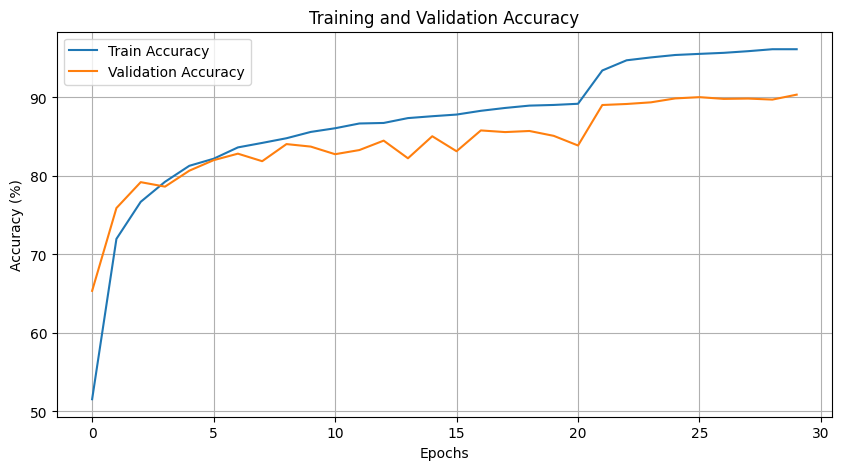

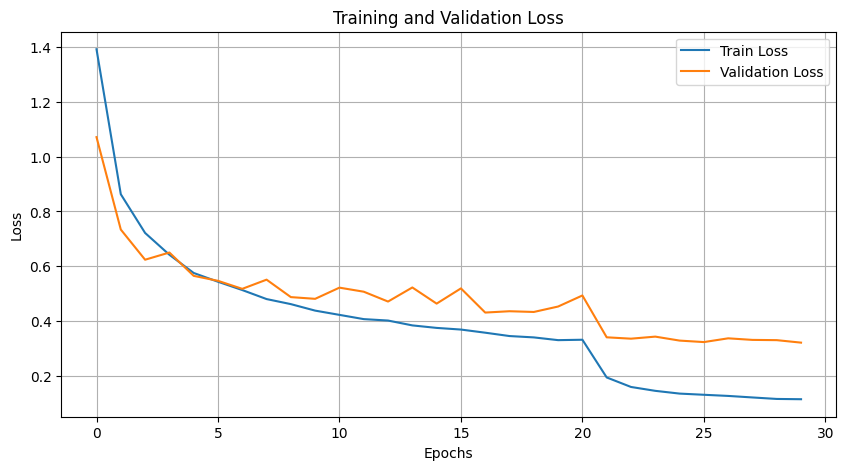

In [9]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()
